# ***Importing Libraries & Packaging:***

In [3]:
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from google.colab import drive

#deployment libararied
!pip install transformers
!pip install gradio 
!pip inslall -- upgrade --no-cache-dir gdown
from transformers import BartForSequenceClassification
from transformers import BertTokenizer
import gradio as gr 
import requests
import tensorflow as tf 
from transformers import AutoModelForSeq2SeqLM,AutoTokenizer

!gdown 1--2UyWwjeQQ-NmirwM_abZF0nJze9MC_

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "inslall" - maybe you meant "install"
Downloading...
From: https://drive.google.com/uc?id=1--2UyWwjeQQ-NmirwM_abZF0nJze9MC_
To: /content/my_modelF_weights.h5
100% 94.6M/94.6M [00:00<00:00, 241MB/s]


# ***Calling The Dataset:***






In [4]:
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/"
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces 
!unzip /content/140k-real-and-fake-faces.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: dataset/real_vs_fake/real-

In [6]:
Fake_Image = Image.open("/content/dataset/real_vs_fake/real-vs-fake/train/fake/019KDB5AQ4.jpg")
Real_Image= Image.open("/content/dataset/real_vs_fake/real-vs-fake/train/real/00006.jpg")

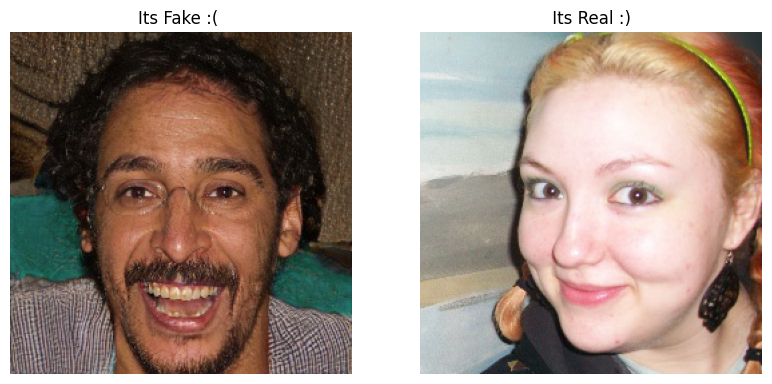

In [7]:
plt.figure(figsize=(15, 15))
i = 0
images = [Fake_Image,Real_Image]
classnames =['Its Fake :( ',' Its Real :) '] 
for item in images:
  ax = plt.subplot(1, 3, i+1)
  plt.imshow(item)
  plt.title(classnames[i])
  plt.axis("off")
  i+=1

In [8]:

BATCH_SIZE = 16 #Define Batch 

IMG_SIZE = (224, 224) #resize images

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory("/content/dataset/real_vs_fake/real-vs-fake/train",
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMG_SIZE)

Found 100000 files belonging to 2 classes.


In [10]:
test_dataset = tf.keras.utils.image_dataset_from_directory("/content/dataset/real_vs_fake/real-vs-fake/test",
                                                            shuffle=False,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 20000 files belonging to 2 classes.


In [11]:
valid_dataset = tf.keras.utils.image_dataset_from_directory("/content/dataset/real_vs_fake/real-vs-fake/valid",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 20000 files belonging to 2 classes.


In [12]:
print(valid_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# print the valid dataset
for images, labels in valid_dataset:
    print(labels)

# ***Training The Model:***

In [19]:
input_shape = (224, 224, 3) 

ResNet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


94765736/94765736 [==============================] - 0s 0us/step


In [20]:
ResNet_model.trainable = False

In [21]:
model = tf.keras.Sequential([
    ResNet_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation='relu'),  
    Dense(1, activation='sigmoid') 
    #Relu ==> if the values less than 0 relu make this all values equal to zero 
    #sigmoid ==> outputs values in the range of 0 to 1.
])

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
!pip3 install h5py
model.save_weights('my_model_weights.h5')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
______________________________________

In [25]:
filepath="/content/drive/MyDrive/ANN.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [26]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('/content/drive/MyDrive/ANN/log.csv', append=True, separator=';')



In [27]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val/mAP', min_delta=0.0, patience=10, verbose=1, mode='max') 

In [28]:
from ctypes import c_size_t
callbacks_list = [checkpoint,csv_logger,early_stopping]


In [29]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/ANN.hdf5')

In [34]:
epochs = 30
history = model.fit(train_dataset, validation_data=valid_dataset,initial_epoch=30 , epochs=epochs, callbacks=callbacks_list)


In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1250/1250 [==============================] - 73s 58ms/step - loss: 0.3482 - accuracy: 0.9291
Test accuracy : 0.9291499853134155


In [38]:
columns = history.columns[0].split(';')
new_history = history.DataFrame(history[history.columns[0]].str.split(';').tolist(), columns=columns)



In [39]:
# fig = plt.figure()
# plt.plot(model.history['loss'], color='teal', label='loss')
# plt.plot(model.history['val_loss'], color='orange', label='val_loss')
# fig.suptitle('Loss', fontsize=20)
# plt.legend(loc="upper left")
# plt.show()

# Testing for a random image:

In [40]:
y_pred = model.predict(test_dataset)

1250/1250 [==============================] - 64s 51ms/step


(1, 224, 224, 3)

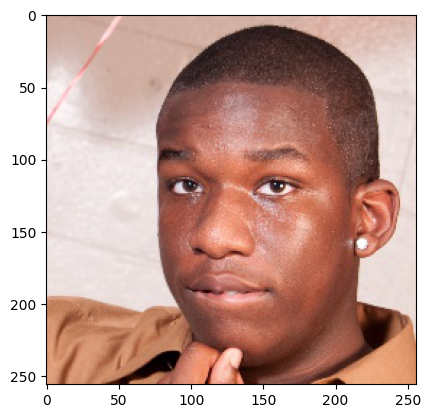

In [41]:
import PIL
from PIL import Image
im1 = Image.open('/content/dataset/real_vs_fake/real-vs-fake/test/real/01423.jpg')
im2=im1.resize((224,224))
p1 = np.array(im2)
p1=p1/255
plt.imshow(im1)
p1 = np.expand_dims(p1, axis=0)
p1.shape

In [42]:
Image_Test=np.argmax(model.predict(p1),axis=-1)
print(Image_Test)
if Image_Test== [0]:
    print('Fake Face :( ')
else:
    print("Real Face :) ")

1/1 [==============================] - 0s 51ms/step
[0]
Fake Face :( 


# ***Deployment Model***

In [43]:
!pip install transformers
!pip install gradio 
!pip inslall -- upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "inslall" - maybe you meant "install"


In [44]:
from transformers import BartForSequenceClassification
from transformers import BertTokenizer
import gradio as gr 
import requests
import tensorflow as tf 
from transformers import AutoModelForSeq2SeqLM,AutoTokenizer

In [45]:
ResNet50 =tf.keras.applications.ResNet50("/content/my_modelF_weights.h5")

102967424/102967424 [==============================] - 0s 0us/step


In [46]:
labels= ['Fack', 'Real']

In [47]:
def Img_predict(img):
  # reshape the input image to a 4D array with shape (batch_size, 224, 224, 3)
  img = img.reshape((-1, 256, 256, 3))
  # apply the same preprocessing that was done on the images used to train the MobileNetV2 model
  img = tf.keras.applications.resnet50.preprocess_input(img)

  # get model prediction
  prediction = ResNet50.predict(img).flatten()
  prediction = prediction.argmax()
  prediction = labels[prediction]
  return prediction

In [48]:
demo = gr.Interface(
    fn=Img_predict, 
    inputs=gr.Image(shape=(256, 256),label="Upload an Image"), 
    outputs=gr.Textbox(label="Predicted Class"), 
    title="Image Classification System",
    description= "This is an Image Classification System, it takes an image as input and returns it's class"
)

demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>